In [127]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import random
import matplotlib.pyplot as plt
from skimage.util import random_noise
from tensorflow.keras.layers import Layer, Conv2D, Add, ReLU, Concatenate, GlobalAveragePooling2D, Multiply, Input, Lambda,  MaxPooling2D, UpSampling2D
from tensorflow.keras.models import Model
from keras.models import load_model
from tensorflow.keras.saving import register_keras_serializable


In [128]:
def plot_side_by_side(x_noisy, x_original, n=10):
    """
    Visualizza n coppie di immagini affiancando l'immagine rumorosa e quella originale per immagini a colori.
    """
    plt.figure(figsize=(20, 4))
    for i in range(n):
        # Immagine rumorosa
        ax = plt.subplot(2, n, i+1)
        plt.imshow(x_noisy[i])
        plt.title("Rumorosa")
        plt.axis('off')

        # Immagine originale
        ax = plt.subplot(2, n, i+1+n)
        plt.imshow(x_original[i])
        plt.title("Originale")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

In [129]:

def plot_denoising_results(x_test_noisy, decoded_imgs, x_test, n=10):
    """
    Visualizza n immagini rumorose, le rispettive immagini denoised e quelle originali.
    """
    plt.figure(figsize=(20, 4))
    n = 10
    for i in range(n):
        # Immagine rumorosa
        ax = plt.subplot(3, n, i + 1)
        plt.imshow(x_test_noisy[i])
        plt.title("Rumorosa")
        plt.axis('off')
        # Immagine denoised
        ax = plt.subplot(3, n, i + 1 + n)
        plt.imshow(decoded_imgs[i])
        plt.title("Denoised")
        plt.axis('off')
        # Immagine originale
        ax = plt.subplot(3, n, i + 1 + 2*n)
        plt.imshow(x_test[i])
        plt.title("Originale")
        plt.axis('off')
    plt.tight_layout()
    plt.show()



In [130]:
def plot_side_by_side(x_noisy, x_original, n=10):
    """
    Visualizza n coppie di immagini affiancando l'immagine rumorosa e quella originale per immagini a colori.
    """
    plt.figure(figsize=(20, 4))
    for i in range(n):
        # Immagine rumorosa
        ax = plt.subplot(2, n, i+1)
        plt.imshow(x_noisy[i])
        plt.title("Rumorosa")
        plt.axis('off')

        # Immagine originale
        ax = plt.subplot(2, n, i+1+n)
        plt.imshow(x_original[i])
        plt.title("Originale")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

In [131]:
# MeanShift: sottrae (o aggiunge) la media RGB
@register_keras_serializable("MeanShift")
class MeanShift(Layer):
    def __init__(self, rgb_mean, sign=-1, **kwargs):
        """
        rgb_mean: tupla con la media dei canali R, G, B.
        sign: -1 per sottrarre la media, 1 per aggiungerla.
        """
        super(MeanShift, self).__init__(**kwargs)
        self.rgb_mean = tf.constant(rgb_mean, dtype=tf.float32)
        self.sign = sign

    def call(self, x):
        # x è atteso in formato (batch, altezza, larghezza, 3)
        # Sfruttiamo Lambda per eseguire l'operazione per ogni elemento
        # Nota: non stiamo scalando per std in questo esempio
        return x + self.sign * self.rgb_mean

# BasicBlock: Conv2D seguita da attivazione ReLU
@register_keras_serializable("BasicBlock")
class BasicBlock(Layer):
    def __init__(self, out_channels, kernel_size=3, stride=1, use_bias=False, **kwargs):
        super(BasicBlock, self).__init__(**kwargs)
        self.conv = Conv2D(out_channels, kernel_size, strides=stride,
                           padding='same', use_bias=use_bias)
        self.relu = ReLU()

    def call(self, x):
        return self.relu(self.conv(x))

# ResidualBlock: due convoluzioni con skip connection(come lavora cuda con 2 thread -> 2 filtri applicati e poi si uniscono i risultati)
@register_keras_serializable("ResidualBlock")
class ResidualBlock(Layer):
    def __init__(self, out_channels, **kwargs):
        super(ResidualBlock, self).__init__(**kwargs)
        self.conv1 = Conv2D(out_channels, 3, strides=1, padding='same')
        self.relu = ReLU()
        self.conv2 = Conv2D(out_channels, 3, strides=1, padding='same')

    def call(self, x):
        residual = self.conv1(x)
        residual = self.relu(residual)
        residual = self.conv2(residual)
        out = Add()([x, residual])
        return ReLU()(out)

# EResidualBlock: versione estesa con convoluzioni a gruppi
@register_keras_serializable("EResidualBlock")
class EResidualBlock(Layer):
    def __init__(self, out_channels, groups=1, **kwargs):
        super(EResidualBlock, self).__init__(**kwargs)
        self.conv1 = Conv2D(out_channels, 3, strides=1, padding='same', groups=groups)
        self.relu = ReLU()
        self.conv2 = Conv2D(out_channels, 3, strides=1, padding='same', groups=groups)
        self.conv3 = Conv2D(out_channels, 1, strides=1, padding='valid')

    def call(self, x):
        residual = self.conv1(x)
        residual = self.relu(residual)
        residual = self.conv2(residual)
        residual = self.relu(residual)
        residual = self.conv3(residual)
        out = Add()([x, residual])
        return ReLU()(out)

# Merge_Run_dual: due rami convoluzionali con dilatazioni diverse, poi fusione e skip connection
@register_keras_serializable("MergeRunDual")
class MergeRunDual(Layer):
    def __init__(self, out_channels, **kwargs):
        super(MergeRunDual, self).__init__(**kwargs)
        # Primo ramo
        self.conv1a = Conv2D(out_channels, 3, strides=1, padding='same')
        self.relu1a = ReLU()
        self.conv1b = Conv2D(out_channels, 3, strides=1, padding='same', dilation_rate=2)
        self.relu1b = ReLU()
        # Secondo ramo
        self.conv2a = Conv2D(out_channels, 3, strides=1, padding='same', dilation_rate=3)
        self.relu2a = ReLU()
        self.conv2b = Conv2D(out_channels, 3, strides=1, padding='same', dilation_rate=4)
        self.relu2b = ReLU()
        # Gogeta
        self.conv3 = Conv2D(out_channels, 3, strides=1, padding='same')
        self.relu3 = ReLU()

    def call(self, x):
        branch1 = self.relu1a(self.conv1a(x))
        branch1 = self.relu1b(self.conv1b(branch1))

        branch2 = self.relu2a(self.conv2a(x))
        branch2 = self.relu2b(self.conv2b(branch2))

        merged = Concatenate()([branch1, branch2])
        merged = self.relu3(self.conv3(merged))
        return Add()([merged, x])

# CALayer: Channel Attention Layer
@register_keras_serializable("CALayer")
class CALayer(Layer):
    def __init__(self, channel, reduction=16, **kwargs):
        super(CALayer, self).__init__(**kwargs)
        self.channel = channel
        self.reduction = reduction
        self.conv1 = Conv2D(channel // reduction, 1, strides=1, padding='same')
        self.relu = ReLU()
        self.conv2 = Conv2D(channel, 1, strides=1, padding='same', activation='sigmoid') #sigmoid: risultato tra 0 e 1

    def call(self, x):
        # Calcolo della media globale per canale
        y = tf.reduce_mean(x, axis=[1, 2], keepdims=True)
        y = self.relu(self.conv1(y))
        y = self.conv2(y)
        return Multiply()([x, y])

# Block: combinazione di MergeRunDual, ResidualBlock, EResidualBlock e CALayer
@register_keras_serializable("Block")
class Block(Layer):
    def __init__(self, out_channels, **kwargs):
        super(Block, self).__init__(**kwargs)
        self.merge_run_dual = MergeRunDual(out_channels)
        self.residual_block = ResidualBlock(out_channels)
        self.e_residual_block = EResidualBlock(out_channels)
        self.ca = CALayer(out_channels)

    def call(self, x):
        r1 = self.merge_run_dual(x)
        r2 = self.residual_block(r1)
        r3 = self.e_residual_block(r2)
        out = self.ca(r3)
        return out

# RIDNET: il modello final
@register_keras_serializable("RIDNET")
def RIDNET(n_feats=64, rgb_range=1.0):
    """
    n_feats: numero di feature channels usate all'interno del modello.<br>
    rgb_range: scala dei valori RGB (ad es. 1.0 se l'input è normalizzato [0,1]).
    """
    rgb_mean = (0.4488, 0.4371, 0.4040)

    input_layer = Input(shape=(None, None, 3))

    # Sottosottrai la media (MeanShift con sign=-1)
    sub_mean = MeanShift(rgb_mean, sign=-1)
    x = sub_mean(input_layer)

    # Testa: BasicBlock (conv + ReLU)
    head = Conv2D(n_feats, 3, strides=1, padding='same', activation='relu')(x)

    # Serie di blocchi
    b1 = Block(n_feats)(head)
    b2 = Block(n_feats)(b1)
    b3 = Block(n_feats)(b2)
    b4 = Block(n_feats)(b3)

    # Coda: convoluzione finale per ottenere 3 canali
    tail = Conv2D(3, 3, strides=1, padding='same')(b4)

    # Aggiungi la media (MeanShift con sign=+1)
    add_mean = MeanShift(rgb_mean, sign=1)
    res = add_mean(tail)

    # Connessione residua a livello di immagine: somma con l'input originale
    output = Add()([res, input_layer])

    model = Model(inputs=input_layer, outputs=output)
    return model

In [132]:
def preprocess(sample, img_size=(256, 256)):
    """
    Preprocessa una singola immagine:
      - Normalizza (0, 1)
      - Ridimensiona a img_size
    """
    image = tf.cast(sample['image'], tf.float32) / 255.0
    image = tf.image.resize(image, img_size)
    return image

def load_dataset(split='train', img_size=(256,256), batch_size=16):
    """
    Carica il dataset Oxford-IIIT Pet da tfds e applica il preprocessamento.
    Ritorna un dataset in batch.
    """
    ds_split = 'train[:80%]'
    if(split == 'validation'):
      ds_split = 'train[80%:]'
    elif(split != 'train' or split != 'validation'):
      ds_split = 'test'

    dataset = tfds.load('oxford_iiit_pet', split=ds_split, as_supervised=False)  # as_supervised=False per mantenere dict
    dataset = dataset.map(lambda sample: preprocess(sample, img_size))  # Preprocessing
    dataset = dataset.shuffle(1024).batch(batch_size).prefetch(tf.data.AUTOTUNE)  # Ottimizza il caricamento
    return dataset

In [133]:
# Parametri
img_size = (112, 112)
batch_size = 20
noise_factor = 0.4
epochs = 50

# Caricamento dataset
train_ds = load_dataset(split='train',       img_size=img_size, batch_size=batch_size )
valid_ds = load_dataset( split='validation', img_size=img_size, batch_size=batch_size )
test_ds  = load_dataset(split='test',        img_size=img_size, batch_size=batch_size )

In [134]:
def add_noise(x, noise_factor=0.1):
    noise = tf.random.normal(shape=tf.shape(x), mean=0.0, stddev=1.0)
    x_noisy = x + noise_factor * noise
    return x_noisy

In [135]:
train_ds_noisy = train_ds.map(lambda x: (add_noise(x, noise_factor), x))
valid_ds_noisy = train_ds.map(lambda x: (add_noise(x, noise_factor), x))


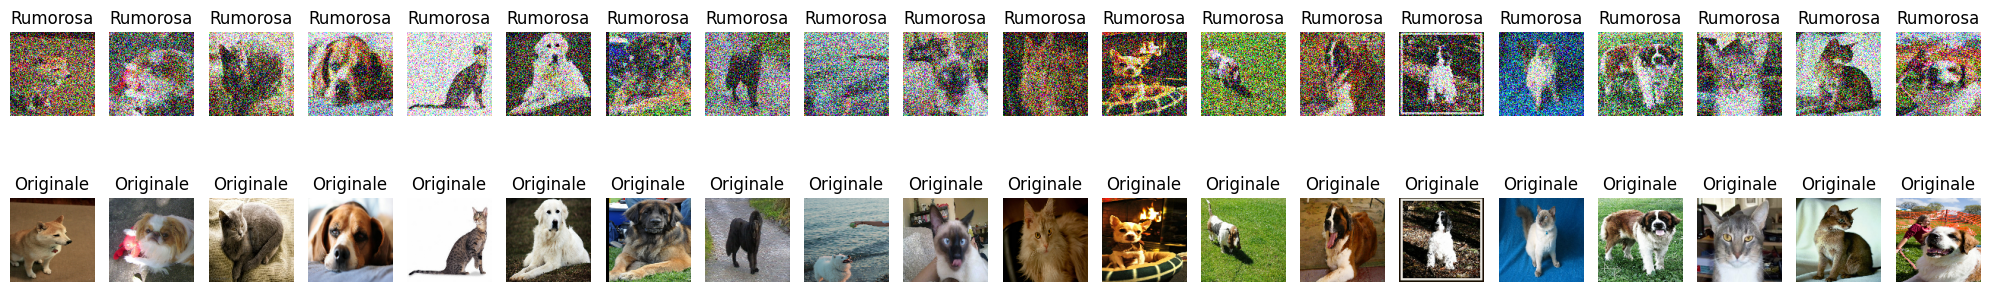

In [136]:
# Prendi un batch dal dataset (ad esempio, il primo batch)
batch = next(iter(train_ds_noisy))

x_noisy_batch, x_original_batch = batch

# Converti i tensori in array NumPy
x_noisy_np = x_noisy_batch.numpy()
x_original_np = x_original_batch.numpy()

# Usa la funzione plot_side_by_side per visualizzare n immagini
plot_side_by_side(x_noisy_np, x_original_np, n=batch_size)


In [137]:
model = RIDNET(n_feats=32, rgb_range=1.0)
model.compile(optimizer='adam', loss='mse', metrics=['accuracy'] )
model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, None,      │          0 │ -                 │
│ (InputLayer)        │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mean_shift_10       │ (None, None,      │          0 │ input_layer_5[0]… │
│ (MeanShift)         │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_250 (Conv2D) │ (None, None,      │        896 │ mean_shift_10[0]… │
│                     │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_20 (Block)    │ (None, None,      │     93,666 │ conv2d_250[0][0]  │
│                     │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_21 (Block)    │ (None, None,      │     93,666 │ block_20[0][0]    │
│                     │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_22 (Block)    │ (None, None,      │     93,666 │ block_21[0][0]    │
│                     │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_23 (Block)    │ (None, None,      │     93,666 │ block_22[0][0]    │
│                     │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_299 (Conv2D) │ (None, None,      │        867 │ block_23[0][0]    │
│                     │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mean_shift_11       │ (None, None,      │          0 │ conv2d_299[0][0]  │
│ (MeanShift)         │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_413 (Add)       │ (None, None,      │          0 │ mean_shift_11[0]… │
│                     │ None, 3)          │            │ input_layer_5[0]… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 376,427 (1.44 MB)

 Trainable params: 376,427 (1.44 MB)

 Non-trainable params: 0 (0.00 B)

In [138]:
history = model.fit(train_ds_noisy,
              epochs=epochs,
              batch_size=batch_size,
              shuffle=True,
              validation_data=valid_ds_noisy)

Epoch 1/50
184/184 ━━━━━━━━━━━━━━━━━━━━ 90s 367ms/step - accuracy: 0.4134 - loss: 0.1904 - val_accuracy: 0.5664 - val_loss: 0.0251
Epoch 2/50
184/184 ━━━━━━━━━━━━━━━━━━━━ 66s 344ms/step - accuracy: 0.5299 - loss: 0.0204 - val_accuracy: 0.5998 - val_loss: 0.0141
Epoch 3/50
184/184 ━━━━━━━━━━━━━━━━━━━━ 66s 346ms/step - accuracy: 0.5829 - loss: 0.0135 - val_accuracy: 0.5927 - val_loss: 0.0120
Epoch 4/50
184/184 ━━━━━━━━━━━━━━━━━━━━ 66s 346ms/step - accuracy: 0.6113 - loss: 0.0113 - val_accuracy: 0.6173 - val_loss: 0.0101
Epoch 5/50
184/184 ━━━━━━━━━━━━━━━━━━━━ 71s 376ms/step - accuracy: 0.6259 - loss: 0.0101 - val_accuracy: 0.6579 - val_loss: 0.0095
Epoch 6/50
184/184 ━━━━━━━━━━━━━━━━━━━━ 67s 352ms/step - accuracy: 0.6513 - loss: 0.0096 - val_accuracy: 0.6238 - val_loss: 0.0092
Epoch 7/50
184/184 ━━━━━━━━━━━━━━━━━━━━ 66s 345ms/step - accuracy: 0.6570 - loss: 0.0092 - val_accuracy: 0.6635 - val_loss: 0.0098
Epoch 8/50
184/184 ━━━━━━━━━━━━━━━━━━━━ 66s 346ms/step - accuracy: 0.6696 - loss: 0

In [139]:
test_ds_noisy  = test_ds.map(lambda x: (add_noise(x, noise_factor), x))


In [140]:
decoded_imgs = model.predict(test_ds_noisy)

184/184 ━━━━━━━━━━━━━━━━━━━━ 20s 87ms/step


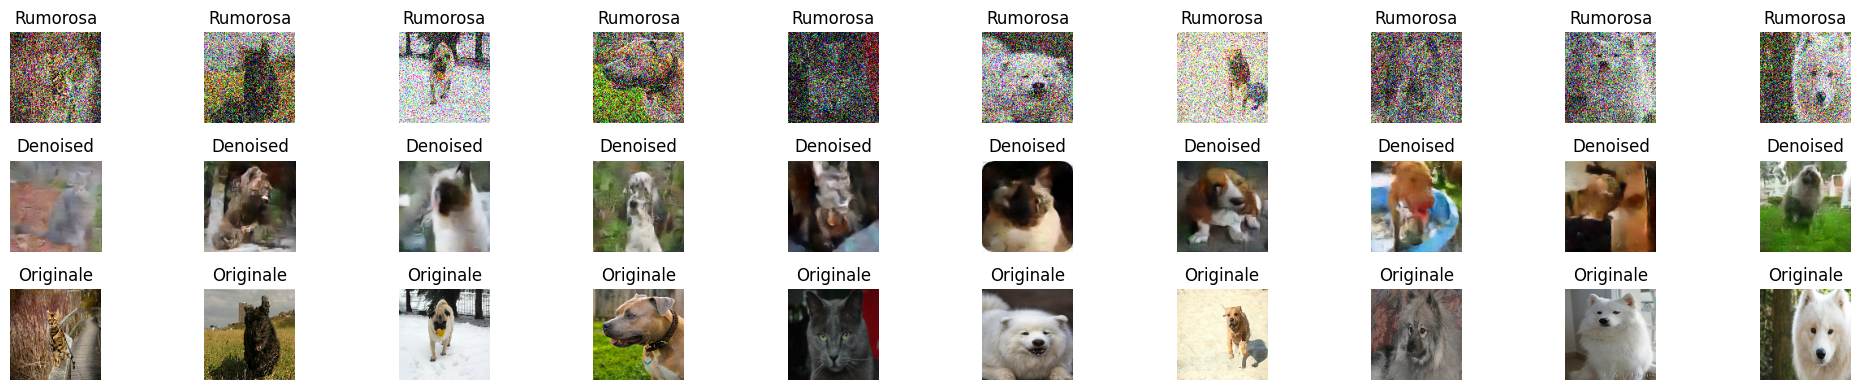

In [141]:
noisy_imgs = []
clean_imgs = []

for noisy_batch, clean_batch in test_ds_noisy:
    noisy_imgs.extend(noisy_batch.numpy())
    clean_imgs.extend(clean_batch.numpy())

noisy_imgs = np.array(noisy_imgs)
clean_imgs = np.array(clean_imgs)

plot_denoising_results(noisy_imgs, decoded_imgs, clean_imgs, n=10)

In [142]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(epochs)

In [143]:
model.save('new_RIDNET.keras')

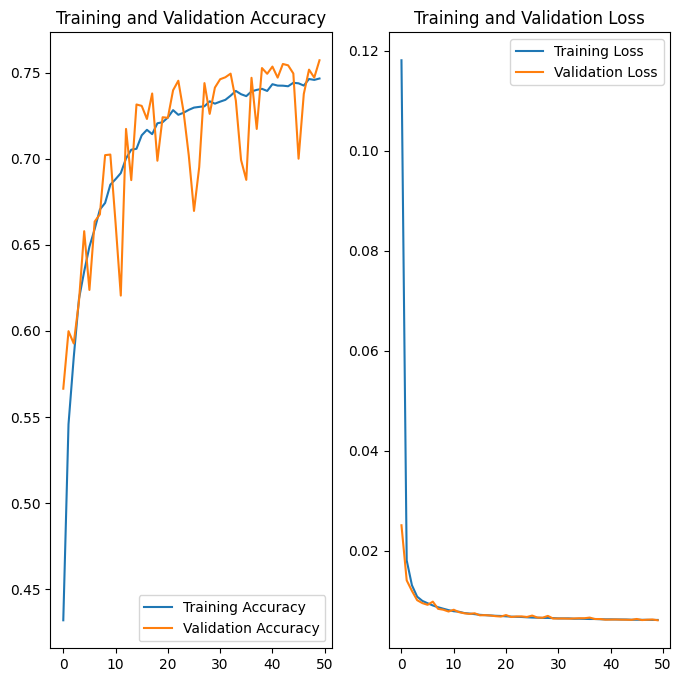

In [144]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [145]:
from skimage.metrics import peak_signal_noise_ratio as psnr

In [146]:
psnr_values = [psnr(x_noisy_np[i], decoded_imgs[i], data_range=1.0) for i in range(len(x_noisy_np))]


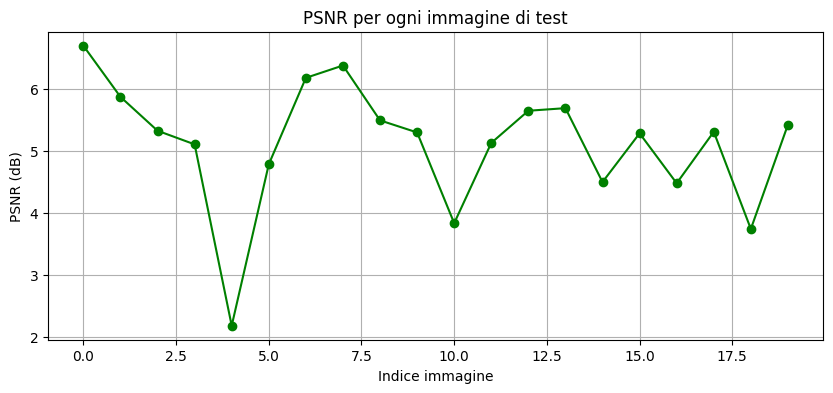

Media PSNR sul test set: 5.12 dB


In [147]:

# Plot dei PSNR per ogni immagine
plt.figure(figsize=(10, 4))
plt.plot(psnr_values, marker='o', linestyle='-', color='green')
plt.title('PSNR per ogni immagine di test')
plt.xlabel('Indice immagine')
plt.ylabel('PSNR (dB)')
plt.grid(True)
plt.show()

# (Facoltativo) Media PSNR
print(f"Media PSNR sul test set: {np.mean(psnr_values):.2f} dB")